In [175]:
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR # scheduler
import numpy as np
import math
import matplotlib.pyplot as plt
import copy


A GLLVM is a model with q latent variables, n observations, and p responses, which can be of different types.

In [176]:
n = 1000
p = 100
q = 1

DIMENSIONS_Z = (n, q)
DIMENSIONS_Y = (n, p) 

They can be of many response types. Here for the sake of illutration we will consider 3 response types: gaussian, binary, and poisson.

We allow for transformation of the data, which we account for in the estimation. In particular, Poisson data may be numerically problematic because their conditional expectation is the exponential of the linear predictor. Small differences in the latter can result in dramatic differences in the gradient. For instance, we can transform poisson with the following function $x \rightarrow \log(x+1)$. This transforms is needed in 2 places: for encoding, and at the loss function for computing the gradient.

## Computing the scale parameter

The scale parameter is computed in a second step (on the fit residual). They are updated at every iteration. This is not yet implemented.

In [177]:

response_types = {
    'gaussian': [i for i in range(round(p/3))],
    'binary': [i for i in range(round(p/3),round(2*p/3))],
    'poisson': [i for i in range(round(2*p/3), p)]
}

# response_types = {
#     'gaussian': [i for i in range(round(p/2))],
#     'binary': [i for i in range(round(p/2),p)],
# }

response_types = {
    'binary': [i for i in range(p)],
}


link = {
    'gaussian' : lambda x: x,
    'binary': lambda x: torch.logit(x),
    'poisson': lambda x: torch.log(x)
}


linkinv = {
    'gaussian': lambda x: x,
    'binary': lambda x: 1/(1+torch.exp(-x)),
    'poisson': lambda x: torch.exp(x) # see below remarks for the standardization of the "counts"
}

response_transform = {
    'gaussian' : lambda x: x,
    'binary': lambda x: x*2 -1,
    'poisson': lambda x: torch.log(x+1)
}



In [178]:
class GLLVM(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.sample = Sample(self.decoder)

class Sample(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.decoder = decoder
    
    def forward(self):
        with torch.no_grad():
            z = torch.randn(DIMENSIONS_Z)
            _, mean = self.decoder(z)
            y = self.sample_response(mean)
            return {"y":y, "z":z}

    
    def sample_response(self, mean):
        y = torch.zeros_like(mean)
        for response_type, response_id in response_types.items():
            if response_type == "binary":
                y[:,response_id] = torch.bernoulli(mean[:,response_id])
            elif response_type == "gaussian":
                y[:,response_id] = torch.randn_like(mean[:,response_id]) + mean[:,response_id]
            elif response_type == "poisson":
                y[:,response_id] = torch.poisson(mean[:,response_id])
        return y


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.wz = nn.Parameter(torch.randn((p,q))) # weights of z: loadings
    
    def forward(self, z):
        linpar = z @ self.wz.T

        # Apply the inverse link to get the conditional expectation
        mean  = torch.zeros_like(linpar)
        for response_type, response_id in response_types.items():
            mean[:,response_id] = linkinv[response_type](linpar[:,response_id])
        
        return linpar, mean
        

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder part
        # input dimension is T * (p+k)... we buuild a fully connected layer but it isn't necessary 
        # output dimension is T*q  + p (for Z and U, respectively)
        self.enc_model = nn.Sequential(
            nn.Linear(in_features=p, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            # nn.Linear(in_features=100, out_features = 100),
            # nn.ReLU(),
            nn.Linear(in_features=100, out_features = q)
        )
        self.optimizer =  torch.optim.Adam(self.parameters(), lr=.01)
        self.scheduler = StepLR(self.optimizer, step_size=100, gamma=.95)
        self.loss = nn.MSELoss()
    
    def forward(self, y, transform_response):
        if transform_response:
            y = y.clone()
            with torch.no_grad():
                for response_type, response_id in response_types.items():
                    y[:,response_id] = response_transform[response_type](y[:,response_id])
        return self.enc_model(y)
    
    
    def fit(self, y, z, epochs=100, verbose=False):
        y = y.clone()
        with torch.no_grad():
            for response_type, response_id in response_types.items():
                y[:,response_id] = response_transform[response_type](y[:,response_id])
        # Fit the encoder
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            zhat = self(y, transform_response = False)
            loss = self.loss(zhat, z)
            if verbose:
                print(f"\nEpoch {epoch}/{epochs}, loss={loss}, max_zhat {torch.max(zhat)}")
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
        return loss
    
    def error(self, y, z):
        with torch.no_grad():
            zhat = self(y, transform_response = True)
            loss = self.loss(zhat, z)
        return loss
    
    def plot(self, y, z):
        with torch.no_grad():
            zhat = self(y, transform_response = True)
        plt.scatter(zhat, z)
        plt.plot([-5,5], [-5,5], color="red")
        plt.show()

class OneLoss(nn.Module):
    def __init__(self):
        super(OneLoss, self).__init__()
    
    def forward(self, y, linpar, ys, linpars):
        """Computes the loss. hat is recontructed y, ys is simulated"""
        y_transformed = torch.zeros_like(y)
        ys_transformed = torch.zeros_like(ys)
        with torch.no_grad():
            for response_type, response_id in response_types.items():
                y_transformed[:,response_id] = response_transform[response_type](y[:,response_id])
                ys_transformed[:,response_id] = response_transform[response_type](ys[:,response_id])


        return -torch.mean(y_transformed* linpar - ys_transformed * linpars) * y.shape[1]
        # return torch.mean(torch.pow(y-linpar, 2) - torch.pow(ys - linpars, 2))
        # loss = torch.mean(y.T @ linpar - ys.T @linpars)/y.shape[0]
        # return loss

In [179]:
model_sample = GLLVM()

data_sample = model_sample.sample()

In [180]:
# for i in range(1):
#     data = model.sample()
#     model.encoder.fit(data['y'], data['z'], verbose=False, epochs=1)

#     data2 = model.sample()
#     print(model.encoder.error(data2['y'], data2['z']))


In [181]:
data_sample["y"]

tensor([[1., 1., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 1., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.]])

In [182]:
model = GLLVM()
criterion = OneLoss()
optimizer = torch.optim.Adam(model.decoder.parameters(), lr=.1)
scheduler = StepLR(optimizer, step_size=10, gamma=.95)
mseLoss = nn.MSELoss()
epochs = 100


In [183]:

losses = []
learning_rates = []
learning_rates_encoder = []
param_values = []

for epoch in range(1, epochs +1):
    optimizer.zero_grad()

    # impute and sample
    with torch.no_grad():
        # data_true["y"] = model.impute(data_true["x"], data_true["y"], mask=mask["y"], nsteps=5)
        # simulate data from the current parameter values, Unconditionally (!)
        data_sim = model.sample()
        # compute the imputing values without the gradients
        zhat_sample = model.encoder(data_sample["y"], transform_response=True)
        zhat_sim = model.encoder(data_sim["y"], transform_response=True)

    # train the encoder on the simulated data
    encoder_loss = model.encoder.fit(data_sim["y"], data_sim["z"], epochs= 1 ) 
    
    # compute the decoded value
    linpar_sample, yhat_sample = model.decoder(zhat_sample)
    linpar_sim, yhat_sim = model.decoder(zhat_sim)



    # model.decoder.wz.grad = mygrad
    loss = criterion(data_sample["y"], linpar_sample,  data_sim["y"], linpar_sim)
    loss.backward()

    # Comparison with the theoretical gradient 
    # ----------------------------------------

    #     # compute the gradient
    # y = torch.zeros_like(data_sim["y"])
    # ys = torch.zeros_like(data_sim["y"])
    # with torch.no_grad():
    #     for response_type, response_id in response_types.items():
    #         y[:,response_id] = response_transform[response_type](data_sample["y"][:,response_id])
    #         ys[:,response_id] = response_transform[response_type](data_sim["y"][:,response_id])



    # mygrad =  -(y.T @ zhat_sample - ys.T @ zhat_sim)/data_sample["y"].shape[0]
    # grad_loss = model.decoder.wz.grad.clone().detach()

    # plt.scatter(mygrad, grad_loss)
    # plt.plot([-.05, .05], [-.05,.05], color="red")
    # plt.show()

    with torch.no_grad():   
        fit = mseLoss(yhat_sample, data_sample["y"])
    
    
    # for param in model.decoder.parameters():
    #     if param.grad is not None:
    #         param.grad.clamp_(-100, 100)


    optimizer.step()
    scheduler.step()

    losses.append(fit.item())
    learning_rates.append(optimizer.param_groups[0]['lr'])
    learning_rates_encoder.append(model.encoder.optimizer.param_groups[0]['lr'])
    param_values.append(model.decoder.wz.clone().detach())

    print(f"\nEpoch {epoch}/{epochs}, loss_fit = {fit.item():.2f}, encoder_loss = {encoder_loss.item():.2f}.")


Epoch 1/100, loss_fit = 0.25, encoder_loss = 1.12.

Epoch 2/100, loss_fit = 0.25, encoder_loss = 0.41.

Epoch 3/100, loss_fit = 0.25, encoder_loss = 0.25.

Epoch 4/100, loss_fit = 0.25, encoder_loss = 0.19.

Epoch 5/100, loss_fit = 0.25, encoder_loss = 0.19.

Epoch 6/100, loss_fit = 0.25, encoder_loss = 0.20.

Epoch 7/100, loss_fit = 0.25, encoder_loss = 0.20.

Epoch 8/100, loss_fit = 0.24, encoder_loss = 0.18.

Epoch 9/100, loss_fit = 0.24, encoder_loss = 0.19.

Epoch 10/100, loss_fit = 0.24, encoder_loss = 0.22.

Epoch 11/100, loss_fit = 0.24, encoder_loss = 0.23.



Epoch 12/100, loss_fit = 0.24, encoder_loss = 0.23.

Epoch 13/100, loss_fit = 0.23, encoder_loss = 0.22.

Epoch 14/100, loss_fit = 0.23, encoder_loss = 0.20.

Epoch 15/100, loss_fit = 0.23, encoder_loss = 0.18.

Epoch 16/100, loss_fit = 0.23, encoder_loss = 0.17.

Epoch 17/100, loss_fit = 0.22, encoder_loss = 0.14.

Epoch 18/100, loss_fit = 0.22, encoder_loss = 0.16.

Epoch 19/100, loss_fit = 0.22, encoder_loss = 0.15.

Epoch 20/100, loss_fit = 0.22, encoder_loss = 0.12.

Epoch 21/100, loss_fit = 0.22, encoder_loss = 0.12.

Epoch 22/100, loss_fit = 0.22, encoder_loss = 0.13.

Epoch 23/100, loss_fit = 0.22, encoder_loss = 0.11.

Epoch 24/100, loss_fit = 0.22, encoder_loss = 0.11.

Epoch 25/100, loss_fit = 0.22, encoder_loss = 0.10.

Epoch 26/100, loss_fit = 0.22, encoder_loss = 0.10.

Epoch 27/100, loss_fit = 0.21, encoder_loss = 0.10.

Epoch 28/100, loss_fit = 0.21, encoder_loss = 0.10.

Epoch 29/100, loss_fit = 0.21, encoder_loss = 0.10.

Epoch 30/100, loss_fit = 0.21, encoder_loss =

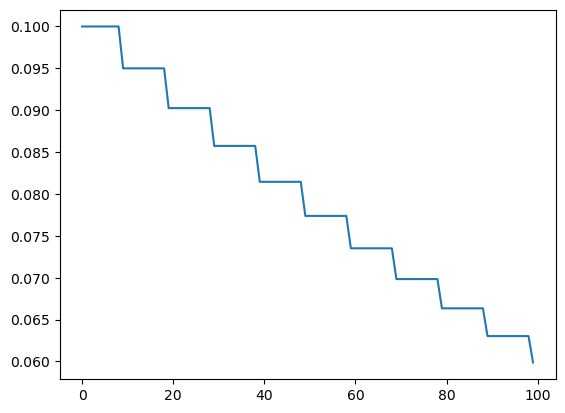

In [184]:
plt.plot(learning_rates)

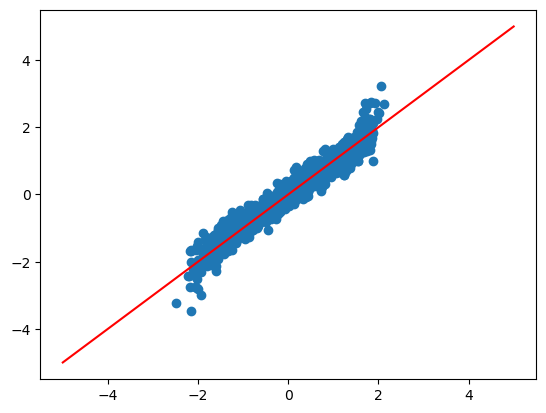

In [185]:
dat = model.sample()
model.encoder.plot(dat['y'], dat['z'])

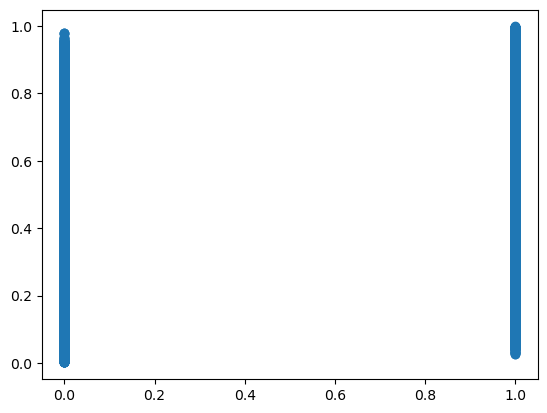

In [186]:
linpar, mean = model.decoder(model.encoder(dat['y'], transform_response = True))
mean = mean.detach().numpy()
plt.scatter(dat['y'], mean)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


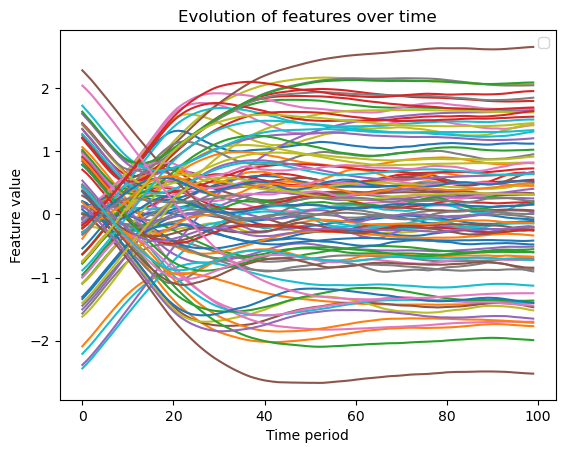

In [187]:
data = np.stack([tensor.flatten().numpy() for tensor in param_values], axis=0)


# Create figure and axes
fig, ax = plt.subplots()

# Loop through each feature
for i in range(data.shape[1]):
    ax.plot(data[:, i])

# Add legend and labels
ax.legend()
plt.xlabel('Time period')
plt.ylabel('Feature value')
plt.title('Evolution of features over time')

# Show the plot
plt.show()



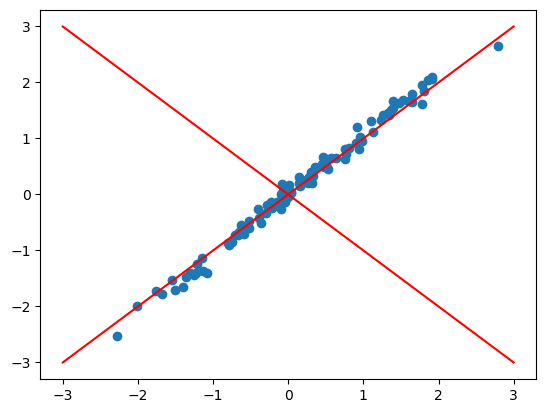

In [188]:
plt.scatter(model_sample.decoder.wz.detach().numpy(), model.decoder.wz.detach().numpy())
plt.plot([-3,3], [-3,3], color="red")
plt.plot([-3,3], [3,-3], color="red")
plt.show()

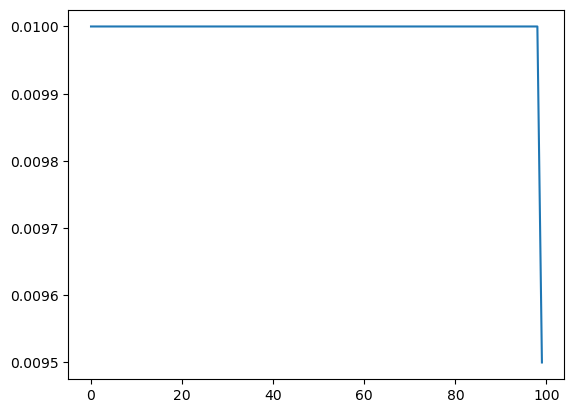

In [189]:
plt.plot(learning_rates_encoder)